# Data Science Homework 4
Try different imbalanced classification datasets using $k$-fold cross validation and various classification methods.
TODO List:
- Make sure we can open all the data as either DataFrame or nparray
- Handle categorical data (tokenize, one-hot encoding, ....)
- Split each dataset into training and testing dataset.
- Perform any necessary sampling, imputaiton, encoding techniques depending on dataset
- Perform 5-fold cross-validation to select datasets.

In [2]:
%matplotlib inline
import os
import imblearn
import numpy as np
import pandas as pd
import xgboost
import lightgbm as lgb
import sklearn.svm as svm
import sklearn.metrics as metrics
import category_encoders as ce # sklearn library
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold, cross_val_score

from sklearn import preprocessing

DATA_DIR = './data'
files = os.listdir(DATA_DIR)
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
print(files)
special_delims = { 'arcene_train.data': ' '}
no_headers = ['covtype.data', 'arcene_train.data']

numMethods = ['clip',
              'standard',
              'minmax',
              'bin',
              'rank'
            ]
ceMethods = [#'onehot',
              'label',
              #'feature',
              'target',
              #'leaveoneout',
              'frequency'
             ]
modelNames = ['forest',
             'xgboost',
             'lightgbm',
             'mlp',
             'svm'
            ]

['abalone.data', 'biodeg.csv', 'Churn_Modelling.csv', 'dataset', 'diabetes_data_upload.csv', 'ECommerce.csv', 'FuelConsumption.csv', 'heart_2020_cleaned.csv', 'IBM.csv', 'income_evaluation.csv', 'loan.csv', 'online_shoppers_intention.csv', 'tae.data', 'Travel_insurance.csv', 'WA_Fn-UseC_-Telco-Customer-Churn.csv']


## Load datasets
Some datasets are in csv format, others have just the data. First convert to `DataFrame`s to allow for numeric, categorical values.

In [3]:

def load(name, header=True):
    try:
        sep = special_delims[name] if name in special_delims else ','
        name = os.path.join(DATA_DIR, name)
        if header:
            df = pd.read_csv(name, sep=sep)
        else:
            print(str(range(1, 10)))
            df = pd.read_csv(name, header=None, sep=sep)

        # Move target column to last
        if  'WineQT.csv' in name:
            cols = list(df.columns)
            x, y = cols.index('quality'), cols.index('Id')
            cols[x], cols[y] = cols[y], cols[x]
            df = df[cols]
        return df
    except:
        pass

## Encode Categorical Values

In [4]:
def encode_per_column(data, encoder):
    for column in data.columns:
        data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
    return data
        
def encode_categorical(data:pd.DataFrame, method='ordinal', y=None,by_row=False):
    if method == 'ordinal':
        encoder = ce.OrdinalEncoder()
    elif method == 'onehot':
        encoder = ce.OneHotEncoder()
    elif method == 'label':
        encoder = preprocessing.LabelEncoder()
        if by_row:
            return encode_per_column(data,encoder)
    elif method == 'feature':
        encoder = FeatureHasher(n_features=10, input_type='string')
        cats = data.select_dtypes(include=['object'])
        print(encoder.transform(data[cats.columns]))
        #encoder = encoder.transform(data.dtypes)
        
    elif method == 'target':
        encoder = ce.target_encoder.TargetEncoder()
        cats = data.select_dtypes(include=['object'])
        for column in cats.columns:
            try:
                data.loc[:, column ] = encoder.fit_transform(data.loc[:, column], y)
            except:
                data[column] = ce.OrdinalEncoder().fit_transform(data.loc[:, column])
        return data
        #return encoder.fit_transform(data.loc[cats.columns], y)
    elif method == 'leaveoneout':
        y = data.iloc[:,-1]
        cats = data.select_dtypes(include=['object'])

        encoder = ce.LeaveOneOutEncoder(cols=cats.columns)
        encoder.fit_transform(data.iloc[:,-1],  y)
        return data
      
    
    elif method == 'frequency':
        encoder = ce.CountEncoder()
    return encoder.fit_transform(data)

def scale_features(data:pd.DataFrame, method='standard') -> pd.DataFrame:
    if method == 'standard':
        scaler = preprocessing.StandardScaler()
    elif method == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    elif method == 'clip':
        for column in data.columns:
            p01 = data[column].quantile(.01)
            p99 = data[column].quantile(.99)
            data[column].clip(p01, p99)
        return data
    elif method == 'bin':
        for column in data.columns:
            data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
        return data
    elif method == 'rank':
        for column in data.columns:
            data.loc[:, column] = data[column].rank()
        return data
    
    return scaler.fit_transform(data)

## Train model:
The evalutation should be fixed on 5-fold cross validation, choose from `RandomForest`, `GBDT`, `XGBoost`,`LightBGM`, `CatBoost`, `KNN`, `Logistic Regression`,`MLP`, `SVM`.

Train a new model every iteration of the cross-validation.

In [5]:

def get_model(method):
    if method == 'xgboost':
        model = xgboost.XGBClassifier(5)
    elif method == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
    elif method == 'forest':
        model = RandomForestClassifier(10)
    elif method == 'lightgbm':
        model = lgb.LGBMClassifier()
    elif method == 'mlp':
        model = MLPClassifier()
    elif method == 'svm':
        model = svm.SVC()
    else:
        print(f'{method} not supported.')
        model = None
    return model

def get_metric(method):
    if method == 'acc':
        met = metrics.accuracy_score
    elif method == 'auc':
        met = metrics.auc
    elif method == 'roc_auc':
        met = metrics.roc_auc_score
    elif method == 'f1':
        met = metrics.f1_score
    elif method == 'prc':
        met = metrics.precision_recall_f1_support
    return met

def train(x, y, method='xgboost', metric='acc'):
    # Perform K-Fold cross validation
    metric = get_metric(metric)
    n_items = x.shape[0]
    kf = StratifiedKFold( n_splits=5, shuffle=True)
    model = get_model(method)

    try:
        mean_score = cross_val_score(model, x, y, cv=kf, n_jobs=1)
    except:
        kf = KFold(n_splits=5, shuffle=True)
        mean_score = 0 
        for i, (train_index, test_index) in enumerate(kf.split(x, y)):
            model = get_model(method)
            x_train, x_test = x.iloc[train_index,: ], x.iloc[test_index, :]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # 
            try:
                if y_test.min().item()  != 0 and method == 'xgboost':
                    y_train -= y_train.min().item() # Class labels should be zero-based
            except ValueError:
                pass

            model.fit(x_train, y_train)

            # Evaluate
            preds = model.predict(x_test)
            score = metric(y_test, preds)
            mean_score += score

        mean_score /= (i+1)
    #pri
    #mean_score = cross_val_score(model, x, y.values.ravel(), cv=kf, n_jobs=1)

    return mean_score.mean(axis=0)
        

## P1: How does feature scaling (e.g. performing normalization) affect performance?
With standardization we apply the formula
$$x' = \frac{x - \mu}{\sigma}$$
so that we have 0 mean in the training data.

For One-hot Encoding we should not use this with tree-based models. For these models we can use label encoding, feature-hashing.
We should first encode the categorical values, then train the models on all our datasets both with feature scaling and without.

In [5]:
for file in files:
    print(f'Training on {file}')
   
    df = load(file, False if file in no_headers else True)
    # Encode categorical columns
    cats = df.select_dtypes(include=['object'])
    df = encode_categorical(df)
    
    control = df.copy(deep=True) # Compare with standardized dataset

    df, labels = df.iloc[:, :-1], df.iloc[:, -1]
    control, c_labels = control.iloc[:, :-1], control.iloc[:, -1]
    
    # Feature scaling
    df = pd.DataFrame(scale_features(df))
    
    if file == 'parkinsons.csv':
        continue
        # Train model
    score = train( df, labels, method='forest', metric='acc')
    print(f'train: {file}: avg: {score}')
   
    score = train(control, c_labels, method='forest', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')
    # The performance is mostly the same across models

Training on abalone.data


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


train: abalone.data: avg: 0.21953155889178583


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: abalone.data: avg: 0.23102741884651748


Training on biodeg.csv
train: biodeg.csv: avg: 0.8587677725118483
test: biodeg.csv: avg: 0.8606635071090046


Training on Churn_Modelling.csv
train: Churn_Modelling.csv: avg: 0.8525
test: Churn_Modelling.csv: avg: 0.8553000000000001


Training on dataset
train: dataset: avg: 0.8810246039770814
test: dataset: avg: 0.8839265251095382


Training on diabetes_data_upload.csv
train: diabetes_data_upload.csv: avg: 0.975
test: diabetes_data_upload.csv: avg: 0.9807692307692306


Training on ECommerce.csv
train: ECommerce.csv: avg: 0.6673344908842862
test: ECommerce.csv: avg: 0.6685157302906279


Training on FuelConsumption.csv
train: FuelConsumption.csv: avg: 0.8075912002227792
test: FuelConsumption.csv: avg: 0.7779782790309107


Training on heart_2020_cleaned.csv
train: heart_2020_cleaned.csv: avg: 0.8792914210666207
test: heart_2020_cleaned.csv: avg: 0.8791444519145077


Training on IBM.csv
train: IBM.csv: avg: 0.16666666666666666


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: IBM.csv: avg: 0.15714285714285717


Training on income_evaluation.csv
train: income_evaluation.csv: avg: 0.8488068514266119
test: income_evaluation.csv: avg: 0.8496668730201666


Training on loan.csv
train: loan.csv: avg: 0.8093167701863354
test: loan.csv: avg: 0.8207867494824017


Training on online_shoppers_intention.csv
train: online_shoppers_intention.csv: avg: 0.8957015409570154
test: online_shoppers_intention.csv: avg: 0.894566098945661


Training on tae.data
train: tae.data: avg: 0.6533333333333332
test: tae.data: avg: 0.5866666666666666


Training on Travel_insurance.csv
train: Travel_insurance.csv: avg: 0.799217751224637
test: Travel_insurance.csv: avg: 0.8112552687872613


Training on WA_Fn-UseC_-Telco-Customer-Churn.csv
train: WA_Fn-UseC_-Telco-Customer-Churn.csv: avg: 0.7802096102974385
test: WA_Fn-UseC_-Telco-Customer-Churn.csv: avg: 0.7759493556035874




## P2 When using tree-based algorithms, will usng one-hot encoding for categorical features generate worse performance than using label encoding? Why?
One-hot encoding transforms inputs with a range of $(1,\dots,n)$. This method generates extra columns and usually results in a sparse matrix.

Label Encoding adds replaces each unique class name with an integer.

In [9]:
for file in files:
    df = load(file, False if file in no_headers else True)
    target_column = df.columns[-1]
    label = df.copy(deep=True) # Use label encoding
    
    cats = label.select_dtypes(include=['object'])

    # Ignore files w/ no categorical data, otherw encoder error
    if cats.empty:
        print(f'No categorical in {file}\n')
        continue
        
    one_hot = pd.get_dummies(df.iloc[:, :-1], sparse=False)
    cats = label.select_dtypes(include=['object'])

    # Apply Label Encoder to each column

    label.loc[:, cats.columns] = encode_categorical(label.loc[:, cats.columns], method='label', by_row=True)
    
    # If target column is not categorical, labels will only be one column
    if df.dtypes[target_column] == object:
        n_unique = df[target_column].unique().shape[0] - 1
    else:
        n_unique = 1
    
    x_ohe, y_ohe = one_hot, df[target_column]
    x_label, y_label = label.iloc[:,:-1], label.iloc[:,-1]
    
    #print(f'{file}: xcols: {len(x_label)} ycols: {len(y_label)}')
    #print(one_hot)
    print(f'Training on {file}')

    score = train(x_ohe, y_ohe, method='knn', metric='acc')
    print(f'\tOnehot avg: {score}')
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'\tlabel avg: {score}')
    print('\n')
    ## There is a slight difference in performance (label encoder usually better by a bit)

Training on abalone.data
	Onehot avg: 0.22168953958112486


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	label avg: 0.23389966478526203


Training on biodeg.csv
	Onehot avg: 0.8246445497630331
	label avg: 0.8559241706161137


Training on Churn_Modelling.csv
	Onehot avg: 0.74
	label avg: 0.8488


Training on dataset
	Onehot avg: 0.8572194135490394
	label avg: 0.8844978092349173


Training on diabetes_data_upload.csv
	Onehot avg: 0.9076923076923077
	label avg: 0.9673076923076923


Training on ECommerce.csv
	Onehot avg: 0.6604229195088676
	label avg: 0.6569679606432676


Training on FuelConsumption.csv
	Onehot avg: 0.5549818991924255
	label avg: 0.7981063770537454


Training on heart_2020_cleaned.csv


KeyboardInterrupt: 

## P3
Will feature binning provide performance improvement? When is binning useful (which models or which kinds of datasets)?

Loop through each column in the dataframe and bin individually.
We use LabelEncoder for categorical features on both DataFrames.

In [10]:
for file in files:
    df = load(file, False if file in no_headers else True)
    binned = df.copy(deep=True)

    # Bin each column individually, use LabelEncoder for categorical
    for column in binned.columns:
        if (binned[column].dtype.name == 'int64'
           or binned[column].dtype.name == 'float64'):
            #n_unique = binned[column].unique() 
            binned[column]= pd.cut(binned[column], 5, labels=False, duplicates='drop')
            #binned[column].fillna(0, inplace=True)

            if binned[column].isnull().values.any():
                binned[colum] = 0
        #elif check if column is categorical
        elif binned[column].dtype.name == 'object':
            binned[column] = encode_categorical(binned[column], method='label')
            df[column] = encode_categorical(df[column], method='ordinal')

    # Train
    x_bin, y_bin = binned.iloc[:, :-1], binned.iloc[:, -1]
    x_label, y_label = df.iloc[:, :-1], df.iloc[:, -1]
    
    print(f'Training on {file}')
    score = train(x_bin, y_bin, method='forest', metric='acc')
    print(f'train: {file}: avg: {score}')
    
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')

Training on abalone.data
train: abalone.data: avg: 0.7570005443658138


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: abalone.data: avg: 0.23174655473741512


Training on biodeg.csv
train: biodeg.csv: avg: 0.823696682464455
test: biodeg.csv: avg: 0.8436018957345972


Training on Churn_Modelling.csv
train: Churn_Modelling.csv: avg: 0.8411
test: Churn_Modelling.csv: avg: 0.8485999999999999


Training on dataset
train: dataset: avg: 0.8734765756656557
test: dataset: avg: 0.8752190765082576


Training on diabetes_data_upload.csv
train: diabetes_data_upload.csv: avg: 0.9634615384615385
test: diabetes_data_upload.csv: avg: 0.9673076923076922


Training on ECommerce.csv
train: ECommerce.csv: avg: 0.6586055645127951
test: ECommerce.csv: avg: 0.663696266898177


Training on FuelConsumption.csv
train: FuelConsumption.csv: avg: 0.8456585909217488
test: FuelConsumption.csv: avg: 0.7991311612364245


Training on heart_2020_cleaned.csv
train: heart_2020_cleaned.csv: avg: 0.8968088931972045
test: heart_2020_cleaned.csv: avg: 0.8797729795650339


Training on IBM.csv
train: IBM.csv: avg: 0.7136054421768707


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


test: IBM.csv: avg: 0.1782312925170068


Training on income_evaluation.csv
train: income_evaluation.csv: avg: 0.8260188091026415
test: income_evaluation.csv: avg: 0.8537208374783225


Training on loan.csv
train: loan.csv: avg: 0.7976811594202898
test: loan.csv: avg: 0.8150310559006211


Training on online_shoppers_intention.csv
train: online_shoppers_intention.csv: avg: 0.8354420113544201
test: online_shoppers_intention.csv: avg: 0.8968369829683699


Training on tae.data
train: tae.data: avg: 0.5933333333333334
test: tae.data: avg: 0.5666666666666667


Training on Travel_insurance.csv
train: Travel_insurance.csv: avg: 0.7342556611774236
test: Travel_insurance.csv: avg: 0.8022480158981304


Training on WA_Fn-UseC_-Telco-Customer-Churn.csv
train: WA_Fn-UseC_-Telco-Customer-Churn.csv: avg: 0.7816287542744693
test: WA_Fn-UseC_-Telco-Customer-Churn.csv: avg: 0.7800658510226467




## P4
Compare the performance of 6 different categorical feature encoding methods based on Random Forest, XGBoost LightGBM, MLP, SVM. Which of the 6 encoding methods is better?
TODO: Finish implementing neural network (missing dataloader)

Models to test: 
1. One hot encoding
2. Label Encoding
3. Feature Hasing
4. Frequency Encoding
5. Target Encoding
6. Leave One Out Encoding

In [ ]:
for file in files:
    print(f'Checking {file}')
    df = load(file, header = False if file in no_headers else True)
    cats = df.select_dtypes(include=['object'])
    for method in ceMethods:
        # Encode features
        encoded = df.copy()
        
        
        encoded = encode_categorical(encoded, method=method, by_row=True if method=='label' else False)
        print(type(encoded))
            
        for modelName in modelNames:
            print(modelName)
            # Number of class columns, necessary for OHE
            labelIndex = len(df.iloc[:,-1].unique()) if method == 'onehot' else 1
            #labelIndex = 1
            enc_train, enc_test = encoded.iloc[:,:-labelIndex], encoded.iloc[:,-labelIndex:]
            score = train(enc_train, enc_test.values.ravel(), modelName)
            print(f'\t({method}, {modelName}): {score}')
            

Checking abalone.data
<class 'pandas.core.frame.DataFrame'>
forest


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(label, forest): 0.23389794573532358
xgboost


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following err

	(label, xgboost): nan
lightgbm
	(label, lightgbm): 0.1445950204853451
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(label, mlp): 0.21977509096639256
svm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(label, svm): 0.2645371458040856
<class 'pandas.core.frame.DataFrame'>
forest


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(target, forest): 0.2283875311577801
xgboost
	(target, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following err

	(target, lightgbm): 0.1347907056699997
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization h

	(target, mlp): 0.2729275420450964
svm
	(target, svm): 0.2540122625562272
<class 'pandas.core.frame.DataFrame'>
forest


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(frequency, forest): 0.22456894822794604
xgboost
	(frequency, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following err

	(frequency, lightgbm): 0.112278027676704
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(frequency, mlp): 0.1144354353493969
svm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	(frequency, svm): 0.16495086382259405
Checking biodeg.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.8635071090047394
xgboost
	(label, xgboost): nan
lightgbm
	(label, lightgbm): nan
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, mlp): 0.8189573459715641
svm
	(label, svm): 0.8322274881516588
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.8682464454976303
xgboost
	(target, xgboost): nan
lightgbm
	(target, lightgbm): nan
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(target, mlp): 0.8578199052132701
svm
	(target, svm): 0.8151658767772514
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.8625592417061612
xgboost
	(frequency, xgboost): nan
lightgbm
	(frequency, lightgbm): nan
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, mlp): 0.8625592417061612
svm
	(frequency, svm): 0.8161137440758294
Checking Churn_Modelling.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.8446999999999999
xgboost
	(label, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, lightgbm): 0.8609
mlp
	(label, mlp): 0.6236999999999999
svm
	(label, svm): 0.7963
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.8497
xgboost
	(target, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(target, lightgbm): 0.8597999999999999
mlp
	(target, mlp): 0.6835
svm
	(target, svm): 0.7963
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.8503999999999999
xgboost
	(frequency, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, lightgbm): 0.8603
mlp
	(frequency, mlp): 0.5593
svm
	(frequency, svm): 0.7963
Checking dataset
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.8821823390630266
xgboost
	(label, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, lightgbm): 0.8752224469160769
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

	(label, mlp): 0.8798618132794068
svm
	(label, svm): 0.8862453656892484
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.8798668688911357
xgboost
	(target, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(target, lightgbm): 0.876386922817661
mlp
	(target, mlp): 0.6530637007077855
svm
	(target, svm): 0.8862453656892484
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.8839197842938995
xgboost
	(frequency, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, lightgbm): 0.8723171553758003
mlp
	(frequency, mlp): 0.8148803505224131
svm
	(frequency, svm): 0.8862453656892484
Checking diabetes_data_upload.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.975
xgboost
	(label, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, lightgbm): 0.973076923076923
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

	(label, mlp): 0.9288461538461539
svm
	(label, svm): 0.6634615384615384
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.9692307692307691
xgboost
	(target, xgboost): nan
lightgbm
	(target, lightgbm): 0.9711538461538461
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

	(target, mlp): 0.9
svm
	(target, svm): 0.6153846153846154
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.9692307692307691
xgboost
	(frequency, xgboost): nan
lightgbm
	(frequency, lightgbm): 0.9807692307692308
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, mlp): 0.8442307692307691
svm
	(frequency, svm): 0.8980769230769232
Checking ECommerce.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.6586053991483732
xgboost
	(label, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, lightgbm): 0.6658790359254206
mlp
	(label, mlp): 0.6284178758940013
svm
	(label, svm): 0.68660779693249
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.6623337880854934
xgboost
	(target, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(target, lightgbm): 0.6676061019471661
mlp
	(target, mlp): 0.6489688701475878
svm
	(target, svm): 0.6861535408656827
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.6655139939641986
xgboost
	(frequency, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, lightgbm): 0.6725159369961553
mlp
	(frequency, mlp): 0.6424179172351068
svm
	(frequency, svm): 0.6850621356815082
Checking FuelConsumption.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.7738067390698969
xgboost


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


	(label, xgboost): 0.8604734057365636
lightgbm
	(label, lightgbm): 0.8594263436368699
mlp
	(label, mlp): 0.5507435254803676
svm
	(label, svm): 0.48624338624338626
<class 'pandas.core.frame.DataFrame'>
forest
	(target, forest): 0.792781954887218
xgboost
	(target, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(target, lightgbm): 0.8318796992481203
mlp
	(target, mlp): 0.38484544695071005
svm
	(target, svm): 0.32558061821219714
<class 'pandas.core.frame.DataFrame'>
forest
	(frequency, forest): 0.7484433305485936
xgboost
	(frequency, xgboost): nan
lightgbm


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(frequency, lightgbm): 0.843553327763854
mlp
	(frequency, mlp): 0.4735449735449736
svm
	(frequency, svm): 0.3477749930381509
Checking heart_2020_cleaned.csv
<class 'pandas.core.frame.DataFrame'>
forest
	(label, forest): 0.8884754295720695
xgboost


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train,

	(label, xgboost): nan
lightgbm
	(label, lightgbm): 0.9066996044340906
mlp


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	(label, mlp): 0.9066964774308541
svm


## P5
Which combinations of numerical and categorical feature transformation methods generally lead to better results?

Here we can test the different numerical and categorical methods on each dataset.

In [81]:

for file in files:
    df = load(file, False if file in no_headers else True)
    print(f'Checking: {file}')
    # Encode only numerical columns
    for numMethod in numMethods:
        numcats = df.select_dtypes(include=['float64', 'int64'])
        scale_features(df[numcats.columns], method=numMethod)
        
        # Encode only categorical columns
        for ceMethod in ceMethods:
            cats = df.select_dtypes(include=['object'])
            df.loc[:,cats.columns] = encode_categorical(df[cats.columns], method=ceMethod, y=df.iloc[:,-1], by_row=True if ceMethod=='label'else False)
            x, y = df.iloc[:, :-1], df.iloc[:, -1]
            score = train(x, y, method='forest')
            print(f'\tNumerical: {numMethod}, Categorical: {ceMethod}, Acc: {score}')
            

Checking: abalone.data


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: clip, Categorical: label, Acc: 0.23366472796034726


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: clip, Categorical: target, Acc: 0.23269919491161217


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: clip, Categorical: frequency, Acc: 0.22982522992292925


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: standard, Categorical: label, Acc: 0.23461880067615964


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: standard, Categorical: target, Acc: 0.24132252241927626


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: standard, Categorical: frequency, Acc: 0.22887545483196287


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: minmax, Categorical: label, Acc: 0.22863335529897144


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: minmax, Categorical: target, Acc: 0.23317909635274905


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: minmax, Categorical: frequency, Acc: 0.2319889407787296


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: bin, Categorical: label, Acc: 0.22767469844998994


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: bin, Categorical: target, Acc: 0.2259986247600493


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: bin, Categorical: frequency, Acc: 0.23054608486376527


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: rank, Categorical: label, Acc: 0.22815345385783456


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: rank, Categorical: target, Acc: 0.2353287683007191


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: rank, Categorical: frequency, Acc: 0.22839268830759535
Checking: biodeg.csv
	Numerical: clip, Categorical: label, Acc: 0.8616113744075828


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: target, Acc: 0.8559241706161137
	Numerical: clip, Categorical: frequency, Acc: 0.8559241706161137
	Numerical: standard, Categorical: label, Acc: 0.8492890995260665
	Numerical: standard, Categorical: target, Acc: 0.8559241706161137
	Numerical: standard, Categorical: frequency, Acc: 0.8549763033175355
	Numerical: minmax, Categorical: label, Acc: 0.8568720379146919
	Numerical: minmax, Categorical: target, Acc: 0.8549763033175355
	Numerical: minmax, Categorical: frequency, Acc: 0.8454976303317535


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.8436018957345972
	Numerical: bin, Categorical: target, Acc: 0.8549763033175355
	Numerical: bin, Categorical: frequency, Acc: 0.8530805687203792


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8530805687203792
	Numerical: rank, Categorical: target, Acc: 0.8606635071090049
	Numerical: rank, Categorical: frequency, Acc: 0.8644549763033176
Checking: Churn_Modelling.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.8503000000000001
	Numerical: clip, Categorical: target, Acc: 0.8488
	Numerical: clip, Categorical: frequency, Acc: 0.8514000000000002
	Numerical: standard, Categorical: label, Acc: 0.8493
	Numerical: standard, Categorical: target, Acc: 0.8487
	Numerical: standard, Categorical: frequency, Acc: 0.8452
	Numerical: minmax, Categorical: label, Acc: 0.8516999999999999
	Numerical: minmax, Categorical: target, Acc: 0.8497999999999999
	Numerical: minmax, Categorical: frequency, Acc: 0.8469


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.8493
	Numerical: bin, Categorical: target, Acc: 0.85
	Numerical: bin, Categorical: frequency, Acc: 0.8467


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8484999999999999
	Numerical: rank, Categorical: target, Acc: 0.8496
	Numerical: rank, Categorical: frequency, Acc: 0.8421000000000001
Checking: dataset
	Numerical: clip, Categorical: label, Acc: 0.8815992585102798


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: target, Acc: 0.8816110549376475
	Numerical: clip, Categorical: frequency, Acc: 0.8816043141220089
	Numerical: standard, Categorical: label, Acc: 0.8769582069430403
	Numerical: standard, Categorical: target, Acc: 0.8746309403437815
	Numerical: standard, Categorical: frequency, Acc: 0.8787023929895519
	Numerical: minmax, Categorical: label, Acc: 0.8810246039770814
	Numerical: minmax, Categorical: target, Acc: 0.8792837883383889
	Numerical: minmax, Categorical: frequency, Acc: 0.8804415234243343


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: label, Acc: 0.8856673407482306
	Numerical: bin, Categorical: target, Acc: 0.8810212335692619
	Numerical: bin, Categorical: frequency, Acc: 0.8792821031344792


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8839248399056286
	Numerical: rank, Categorical: target, Acc: 0.8816076845298282
	Numerical: rank, Categorical: frequency, Acc: 0.8769514661274014
Checking: diabetes_data_upload.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.9615384615384615
	Numerical: clip, Categorical: target, Acc: 0.9711538461538461
	Numerical: clip, Categorical: frequency, Acc: 0.976923076923077
	Numerical: standard, Categorical: label, Acc: 0.9769230769230768
	Numerical: standard, Categorical: target, Acc: 0.9634615384615384
	Numerical: standard, Categorical: frequency, Acc: 0.9673076923076923
	Numerical: minmax, Categorical: label, Acc: 0.9653846153846153
	Numerical: minmax, Categorical: target, Acc: 0.9884615384615385
	Numerical: minmax, Categorical: frequency, Acc: 0.9711538461538461


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.9711538461538461
	Numerical: bin, Categorical: target, Acc: 0.9576923076923076
	Numerical: bin, Categorical: frequency, Acc: 0.975


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.9769230769230768
	Numerical: rank, Categorical: target, Acc: 0.978846153846154
	Numerical: rank, Categorical: frequency, Acc: 0.9673076923076923
Checking: ECommerce.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.6674249452230353
	Numerical: clip, Categorical: target, Acc: 0.6629694489230642
	Numerical: clip, Categorical: frequency, Acc: 0.6636038281863657
	Numerical: standard, Categorical: label, Acc: 0.6664237876720824
	Numerical: standard, Categorical: target, Acc: 0.6667888296333044
	Numerical: standard, Categorical: frequency, Acc: 0.6636960601926496
	Numerical: minmax, Categorical: label, Acc: 0.663970151721857
	Numerical: minmax, Categorical: target, Acc: 0.6670598205796023
	Numerical: minmax, Categorical: frequency, Acc: 0.6689700276985407


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: label, Acc: 0.6657893670676753
	Numerical: bin, Categorical: target, Acc: 0.6607863078258712
	Numerical: bin, Categorical: frequency, Acc: 0.6676063086526934


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.6652409773037331
	Numerical: rank, Categorical: target, Acc: 0.6686968870147588
	Numerical: rank, Categorical: frequency, Acc: 0.6575141179875149
Checking: FuelConsumption.csv
	Numerical: clip, Categorical: label, Acc: 0.7875410749094959


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: target, Acc: 0.7811807296017821
	Numerical: clip, Categorical: frequency, Acc: 0.7885324422166528
	Numerical: standard, Categorical: label, Acc: 0.7759454191033137
	Numerical: standard, Categorical: target, Acc: 0.7875132275132275
	Numerical: standard, Categorical: frequency, Acc: 0.784344193817878
	Numerical: minmax, Categorical: label, Acc: 0.7663881927039822
	Numerical: minmax, Categorical: target, Acc: 0.7758563074352548
	Numerical: minmax, Categorical: frequency, Acc: 0.7949484823169033


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.7886048454469506
	Numerical: bin, Categorical: target, Acc: 0.7727095516569201
	Numerical: bin, Categorical: frequency, Acc: 0.785458089668616


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.7917181843497633
	Numerical: rank, Categorical: target, Acc: 0.7737900306321359
	Numerical: rank, Categorical: frequency, Acc: 0.7981063770537455
Checking: heart_2020_cleaned.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.8886380337403649
	Numerical: clip, Categorical: target, Acc: 0.8887005738050939
	Numerical: clip, Categorical: frequency, Acc: 0.888359730452321
	Numerical: standard, Categorical: label, Acc: 0.8885504776497445
	Numerical: standard, Categorical: target, Acc: 0.8889976391125565
	Numerical: standard, Categorical: frequency, Acc: 0.8883190794102471
	Numerical: minmax, Categorical: label, Acc: 0.8885629856626902
	Numerical: minmax, Categorical: target, Acc: 0.8880783001610405
	Numerical: minmax, Categorical: frequency, Acc: 0.8883472224393751


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.8889444800575369
	Numerical: bin, Categorical: target, Acc: 0.888212761300208
	Numerical: bin, Categorical: frequency, Acc: 0.8884910645882519


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

	Numerical: rank, Categorical: label, Acc: 0.8889100830219359
	Numerical: rank, Categorical: target, Acc: 0.8891258462452509
	Numerical: rank, Categorical: frequency, Acc: 0.8881189512031146
Checking: IBM.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: clip, Categorical: label, Acc: 0.15714285714285714
	Numerical: clip, Categorical: target, Acc: 0.16258503401360544


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: clip, Categorical: frequency, Acc: 0.16122448979591836
	Numerical: standard, Categorical: label, Acc: 0.1727891156462585


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: standard, Categorical: target, Acc: 0.16122448979591836
	Numerical: standard, Categorical: frequency, Acc: 0.17006802721088432


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: minmax, Categorical: label, Acc: 0.16122448979591836
	Numerical: minmax, Categorical: target, Acc: 0.15714285714285714


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: minmax, Categorical: frequency, Acc: 0.1741496598639456


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: label, Acc: 0.1768707482993197
	Numerical: bin, Categorical: target, Acc: 0.163265306122449


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: bin, Categorical: frequency, Acc: 0.16734693877551018


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: rank, Categorical: label, Acc: 0.1564625850340136
	Numerical: rank, Categorical: target, Acc: 0.163265306122449


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


	Numerical: rank, Categorical: frequency, Acc: 0.17619047619047618
Checking: income_evaluation.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.8512943259200745
	Numerical: clip, Categorical: target, Acc: 0.8509261433662632
	Numerical: clip, Categorical: frequency, Acc: 0.8475168025317726
	Numerical: standard, Categorical: label, Acc: 0.8514479357293728
	Numerical: standard, Categorical: target, Acc: 0.8496668871668872
	Numerical: standard, Categorical: frequency, Acc: 0.8488373989122492
	Numerical: minmax, Categorical: label, Acc: 0.8507109057258757
	Numerical: minmax, Categorical: target, Acc: 0.8500352441969209
	Numerical: minmax, Categorical: frequency, Acc: 0.8496053347849756


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: label, Acc: 0.8511717068603296
	Numerical: bin, Categorical: target, Acc: 0.850588107474335
	Numerical: bin, Categorical: frequency, Acc: 0.8500659520120599


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8472406208184651
	Numerical: rank, Categorical: target, Acc: 0.8490833632300699
	Numerical: rank, Categorical: frequency, Acc: 0.8503732800888489
Checking: loan.csv
	Numerical: clip, Categorical: label, Acc: 0.7773498964803313


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: target, Acc: 0.7860869565217391
	Numerical: clip, Categorical: frequency, Acc: 0.7889855072463768
	Numerical: standard, Categorical: label, Acc: 0.7949068322981366
	Numerical: standard, Categorical: target, Acc: 0.8006625258799172
	Numerical: standard, Categorical: frequency, Acc: 0.7746169772256729
	Numerical: minmax, Categorical: label, Acc: 0.8062939958592134
	Numerical: minmax, Categorical: target, Acc: 0.7947826086956522
	Numerical: minmax, Categorical: frequency, Acc: 0.7890269151138716


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: label, Acc: 0.7948654244306418
	Numerical: bin, Categorical: target, Acc: 0.789151138716356
	Numerical: bin, Categorical: frequency, Acc: 0.7920496894409939


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.762815734989648
	Numerical: rank, Categorical: target, Acc: 0.7715527950310559
	Numerical: rank, Categorical: frequency, Acc: 0.7861283643892338
Checking: online_shoppers_intention.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.8976480129764802
	Numerical: clip, Categorical: target, Acc: 0.8959448499594485
	Numerical: clip, Categorical: frequency, Acc: 0.8965936739659368
	Numerical: standard, Categorical: label, Acc: 0.8959448499594485
	Numerical: standard, Categorical: target, Acc: 0.8961881589618816
	Numerical: standard, Categorical: frequency, Acc: 0.8961881589618816
	Numerical: minmax, Categorical: label, Acc: 0.8940794809407947
	Numerical: minmax, Categorical: target, Acc: 0.8958637469586375
	Numerical: minmax, Categorical: frequency, Acc: 0.8956204379562044


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.8984590429845903
	Numerical: bin, Categorical: target, Acc: 0.8966747769667478
	Numerical: bin, Categorical: frequency, Acc: 0.8968369829683699


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8965125709651257
	Numerical: rank, Categorical: target, Acc: 0.8948905109489053
	Numerical: rank, Categorical: frequency, Acc: 0.8958637469586375
Checking: tae.data
	Numerical: clip, Categorical: label, Acc: 0.6266666666666666
	Numerical: clip, Categorical: target, Acc: 0.62
	Numerical: clip, Categorical: frequency, Acc: 0.6266666666666667
	Numerical: standard, Categorical: label, Acc: 0.6266666666666667
	Numerical: standard, Categorical: target, Acc: 0.6066666666666666
	Numerical: standard, Categorical: frequency, Acc: 0.64
	Numerical: minmax, Categorical: label, Acc: 0.5866666666666667
	Numerical: minmax, Categorical: target, Acc: 0.5933333333333333
	Numerical: minmax, Categorical: frequency, Acc: 0.6066666666666667
	Numerical: bin, Categorical: label, Acc: 0.6666666666666667
	Numerical: bin, Categorical: target, Acc: 0.6599999999999999
	Numerical: bin, Categorical: frequency, Acc: 0.5399999999999999
	Numerical: rank, Categorical: label, A

C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.7946761515385491
	Numerical: clip, Categorical: target, Acc: 0.8057402883434805
	Numerical: clip, Categorical: frequency, Acc: 0.7981684239838993
	Numerical: standard, Categorical: label, Acc: 0.8016923407971849
	Numerical: standard, Categorical: target, Acc: 0.8012164095034366
	Numerical: standard, Categorical: frequency, Acc: 0.7986861258433223
	Numerical: minmax, Categorical: label, Acc: 0.8087591610445173
	Numerical: minmax, Categorical: target, Acc: 0.8042327506550384
	Numerical: minmax, Categorical: frequency, Acc: 0.7986924547169094
	Numerical: bin, Categorical: label, Acc: 0.7946533675936356


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A va

	Numerical: bin, Categorical: target, Acc: 0.8082680404541598
	Numerical: bin, Categorical: frequency, Acc: 0.8032049415844968


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.8042175613584295
	Numerical: rank, Categorical: target, Acc: 0.7971785881548803
	Numerical: rank, Categorical: frequency, Acc: 0.8057326936951762
Checking: WA_Fn-UseC_-Telco-Customer-Churn.csv


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


	Numerical: clip, Categorical: label, Acc: 0.7783625153235693
	Numerical: clip, Categorical: target, Acc: 0.7830477974385445
	Numerical: clip, Categorical: frequency, Acc: 0.7806339320278728
	Numerical: standard, Categorical: label, Acc: 0.7830472933737661
	Numerical: standard, Categorical: target, Acc: 0.7817683802180786
	Numerical: standard, Categorical: frequency, Acc: 0.7864542672107878
	Numerical: minmax, Categorical: label, Acc: 0.782477599361249
	Numerical: minmax, Categorical: target, Acc: 0.7810598667655978
	Numerical: minmax, Categorical: frequency, Acc: 0.7793534058648945


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')


	Numerical: bin, Categorical: label, Acc: 0.7844661349119298
	Numerical: bin, Categorical: target, Acc: 0.7870227514678366
	Numerical: bin, Categorical: frequency, Acc: 0.7779360765210659


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2092\913187115.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = data[column].rank()


	Numerical: rank, Categorical: label, Acc: 0.7830453779276082
	Numerical: rank, Categorical: target, Acc: 0.7810608748951545
	Numerical: rank, Categorical: frequency, Acc: 0.7833269485128073


## P6
If the number of possible categorical values of a feature is high, which encoding method among target encoding, one-hot encoding, and label encoding will have better performance? Why?

Go through each file, test each encoding method, and measure the $n$ datasets with most unique values.

In [68]:
enc_methods = ['target',
               'onehot',
               'label',
              ]

for file in files:
    df = load(file, header=False if file in no_headers else True)
    print(f'Training on {file}')
    for enc_method in enc_methods:
        df_copy = df.copy()

        # OHE produces this many label columns
        n_labels = df_copy.iloc[:, -1].nunique() if enc_method == 'onehot' else 1
        
        # Encode df using method
        cats = df_copy.iloc[:,:-1].select_dtypes(include=['object'])
        if cats.empty:
            print(f'{file} has not categorical')
            continue

        max_uniques = max([len(df_copy[col].unique()) for col in cats.columns])
        if enc_method == 'onehot':
            print(n_labels)
            x  = pd.get_dummies(df_copy.iloc[:, -1])
            y = df.iloc[:,-1]
        else:
            df_copy.loc[:, cats.columns] = encode_categorical(df_copy.loc[:, cats.columns], method=enc_method, y=df_copy.iloc[:,-1], by_row=True)
            
            x, y = df_copy.iloc[:,:-n_labels], df_copy.iloc[:, -n_labels:]

        # Train model
        score = train(x, y, method='forest')
        print(f'\tmethod: {enc_method},  max unique categories: {max_uniques} score: {score}')
        


Training on abalone.data


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation

	method: target,  max unique categories: 3 score: 0.2398879752456809
28
	method: onehot,  max unique categories: 3 score: 0.9988032547345501


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation

	method: label,  max unique categories: 3 score: 0.23007048104747443
Training on biodeg.csv
biodeg.csv has not categorical
biodeg.csv has not categorical
biodeg.csv has not categorical
Training on Churn_Modelling.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 2932 score: 0.8635000000000002
2
	method: onehot,  max unique categories: 2932 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 2932 score: 0.8474
Training on dataset
	method: target,  max unique categories: 22 score: 0.8827654196157735
2
	method: onehot,  max unique categories: 22 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 22 score: 0.8833485001685204
Training on diabetes_data_upload.csv
	method: target,  max unique categories: 2 score: 0.975
2
	method: onehot,  max unique categories: 2 score: 1.0
	method: label,  max unique categories: 2 score: 0.978846153846154
Training on ECommerce.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 5 score: 0.6615145313985696
2
	method: onehot,  max unique categories: 5 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 5 score: 0.6662413080325769
Training on FuelConsumption.csv
	method: target,  max unique categories: 715 score: 0.7875299359509886
5


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: onehot,  max unique categories: 715 score: 1.0
	method: label,  max unique categories: 715 score: 0.7505708716235032


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

Training on heart_2020_cleaned.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 13 score: 0.8892947044200191
2
	method: onehot,  max unique categories: 13 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 13 score: 0.888150221235479
Training on IBM.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation

	method: target,  max unique categories: 6 score: 0.17346938775510204
37
	method: onehot,  max unique categories: 6 score: 0.9972789115646258


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation

	method: label,  max unique categories: 6 score: 0.1714285714285714
Training on income_evaluation.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 42 score: 0.8511715418152542
2
	method: onehot,  max unique categories: 42 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 42 score: 0.8491755574090902
Training on loan.csv
	method: target,  max unique categories: 23 score: 0.768944099378882
2
	method: onehot,  max unique categories: 23 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 23 score: 0.7918426501035196
Training on online_shoppers_intention.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 10 score: 0.8952149229521492
2
	method: onehot,  max unique categories: 10 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-p

	method: label,  max unique categories: 10 score: 0.8944849959448499
Training on tae.data
tae.data has not categorical
tae.data has not categorical
tae.data has not categorical
Training on Travel_insurance.csv
	method: target,  max unique categories: 2 score: 0.8082515853828337
2


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: onehot,  max unique categories: 2 score: 1.0
	method: label,  max unique categories: 2 score: 0.8057377567940458
Training on WA_Fn-UseC_-Telco-Customer-Churn.csv


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: target,  max unique categories: 7043 score: 0.7753795607781147
2
	method: onehot,  max unique categories: 7043 score: 1.0


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Andres Pon

	method: label,  max unique categories: 7043 score: 0.7861720917478546


C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


## Plot class imbalance

dataset
biodeg.csv
FuelConsumption.csv
Travel_insurance.csv
ECommerce.csv
heart_2020_cleaned.csv
tae.data
diabetes_data_upload.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
loan.csv
online_shoppers_intention.csv
income_evaluation.csv
abalone.data
IBM.csv
Churn_Modelling.csv


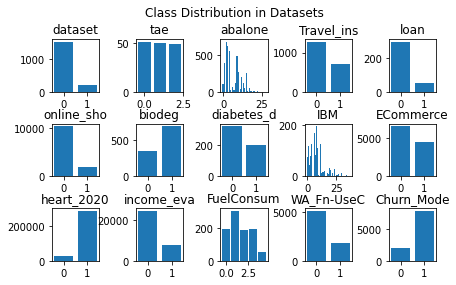

In [12]:
   
fig, axs = plt.subplots(3, 5)
fig.suptitle('Class Distribution in Datasets')
row, col = 0, 0
fig.tight_layout()
for i, file in enumerate(files):
    print(f'{file}')
    df = load(file, False if file in no_headers else True)
    row = row + 1 if i % 3 != 0 else 0
    col = col + 1 if i % 5 != 0 else 0
    
    target = df.iloc[:, -1]
    names, counts = [],[]
    for unique in target.unique():
        count = target[target == unique].count()
        counts.append(count)
        names.append(unique)
    #print(names, counts)
    axs[row, col].bar( range(len(counts)),counts) 
    axs[row,col].set_title(file.split('.')[0][:10])
    
    #plot_imbalance(df, file)
plt.show()
fig.savefig('./report/img/distribution.png')

## Imbalanced data samplers


In [69]:
def get_imb_sampler(method:str, y=None):
    if method == 'nearmiss':
        return imblearn.under_sampling.NearMiss(n_neighbors=get_least_frequent(y))
    elif method == 'clustercentroids':
        return imblearn.under_sampling.ClusterCentroids()
    elif method == 'condensednn':
        return imblearn.under_sampling.CondensedNearestNeighbour(n_neighbors=get_least_frequent(y))
    elif method == 'editednn':
        return imblearn.under_sampling.EditedNearestNeighbours(n_neighbors=get_least_frequent(y))
    elif method == 'neighbourhoodcleaning':
        return imblearn.under_sampling.NeighbourhoodCleaningRule(n_neighbors=get_least_frequent(y))
    elif method == 'tomeklinks':
        return imblearn.under_sampling.TomekLinks()
    elif method == 'onesidedselection':
        return imblearn.under_sampling.OneSidedSelection()
    elif method == 'smote':
        return imblearn.over_sampling.SMOTE()
    elif method == 'borderlinesmote':
        return imblearn.over_sampling.BorderlineSMOTE()
    elif method == 'adasyn':
        return imblearn.over_sampling.ADASYN(n_neighbors=get_least_frequent(y))
    elif method == 'svmsmote':
        return imblearn.over_sampling.SVMSMOTE(k_neighbors=get_least_frequent(y))
    elif method == 'easyensemble':
        return imblearn.ensemble.EasyEnsemble()
    elif method == 'balancecascade':
        return imblearn.ensemble.BalanceCascade()
    
def get_least_frequent(y:pd.Series):
    return min(3, min(y.value_counts()))

def get_imb_sample(x:pd.DataFrame, y:pd.Series, s_method:str='nearmiss'):
    sampler = get_imb_sampler(us_method, y)
    # find least frequent class
    
    #sampler = sampler(n_neighbors=get_least_frequent(y))
    return sampler.fit_resample(x, y)

def train_imb(x:pd.DataFrame, y:pd.DataFrame, model='forest', eval_method='prc'): 
    # TODO: Use OVR classifier to 
    # Perform K-Fold cross validation'
   
    n_items = x.shape[0]
    kf = StratifiedKFold(n_splits=get_least_frequent(y), shuffle=True)
    mean_prec, mean_rec, mean_f, mean_supp = 0, 0, 0, 0
    for i, (train_index, test_index) in enumerate(kf.split(x, y)):
        model = get_model('forest')
        x_train, x_test = x.iloc[train_index,: ], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            
        model.fit(x_train, y_train)
        
        # Evaluate
        preds = model.predict(x_test)
        prec,rec,f,supp =  metrics.precision_recall_fscore_support(y_test, preds, zero_division=0)
        mean_prec += prec
        mean_rec += rec
        mean_f += f
        mean_supp += supp
    mean_prec = mean_prec.mean()
    mean_rec = mean_rec.mean()
    mean_f = mean_f.mean()
    mean_supp = mean_supp.mean()
    return np.array([mean_prec, mean_rec, mean_f, mean_supp], dtype=np.float64) / (i+1)
    #print(f'Mean score over validation: {mean_score} using {method}')

        

## P7
Compare the classification performance of "doing nothing", 7 undersampling,4 oversampling, and 2 ensemble based methods in presence of class imbalance. Which method works generally best and the worst? Why?

Since we are interested in measuring our performance on the minority class, we use precision-recall curve.
First we get the training and testing data, and apply the sampling method on only the training set.

In [71]:
under_sampling_methods = ['nearmiss',
                          'clustercentroids',
                          'condensednn',
                          'editednn',
                          'neighbourhoodcleaning',
                          'tomeklinks',
                          'onesidedselection'
                         ]

over_sampling_methods = ['smote',
                         'borderlinesmote',
                         'adasyn',
                         'svmsmote'
                        ]

for file in files:
    # Heart Dataset meeds too much memory
    if 'heart' in file:
        continue
    df = load(file, False if file in no_headers else True)
    # Encode df
    df = encode_categorical(df)
    # Split into testing and training set
    x, y = df.iloc[:, :-1], df.iloc[:, -1]
    print(f'Seeing: {file}: {get_least_frequent(y)}')

    if get_least_frequent(y) < 2:
        print('Cannot sample with less than two classes.')
        continue
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
    
    # Undersample
    print('\tUndersampling')
    for us_method in under_sampling_methods:
        x_sample, y_sample  = get_imb_sample(x, y, s_method=us_method)
        scores = train_imb(x_sample, y_sample, model='forest')
        print(f'\t{us_method} mean precision: {scores[0]:.3f}, mean recall: {scores[1]:.3f} mean fscore: {scores[2]:.3f}, mean support: {scores[3]:.3f}')
    print('\n\tOversampling')
    for os_method in over_sampling_methods:
        # Do the same thing
        x_sample, y_sample = get_imb_sample(x, y, s_method=os_method)
        scores = train_imb(x_sample, y_sample, model='forest')
        print(f'\t{os_method} mean precision: {scores[0]:.3f}, mean recall: {scores[1]:.3f} mean fscore: {scores[2]:.3f}, mean support: {scores[3]:.3f}')


Seeing: abalone.data: 1
Cannot sample with less than two classes.
Seeing: biodeg.csv: 3
	Undersampling
	nearmiss mean precision: 0.790, mean recall: 0.785 mean fscore: 0.784, mean support: 118.667
	clustercentroids mean precision: 0.831, mean recall: 0.827 mean fscore: 0.827, mean support: 118.667
	condensednn mean precision: 0.765, mean recall: 0.744 mean fscore: 0.750, mean support: 97.333
	editednn mean precision: 0.910, mean recall: 0.910 mean fscore: 0.910, mean support: 135.000
	neighbourhoodcleaning mean precision: 0.896, mean recall: 0.895 mean fscore: 0.895, mean support: 158.500
	tomeklinks mean precision: 0.859, mean recall: 0.851 mean fscore: 0.855, mean support: 167.000
	onesidedselection mean precision: 0.850, mean recall: 0.850 mean fscore: 0.850, mean support: 166.667

	Oversampling
	smote mean precision: 0.859, mean recall: 0.853 mean fscore: 0.856, mean support: 166.500
	borderlinesmote mean precision: 0.855, mean recall: 0.852 mean fscore: 0.853, mean support: 165.83

C:\Users\Andres Ponce\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:190: ConvergenceWarning: Number of distinct clusters (173) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


	clustercentroids mean precision: 0.973, mean recall: 0.973 mean fscore: 0.973, mean support: 66.667
	condensednn mean precision: 0.945, mean recall: 0.943 mean fscore: 0.943, mean support: 53.333
	editednn mean precision: 0.986, mean recall: 0.983 mean fscore: 0.984, mean support: 75.667
	neighbourhoodcleaning mean precision: 0.969, mean recall: 0.969 mean fscore: 0.968, mean support: 80.667
	tomeklinks mean precision: 0.969, mean recall: 0.970 mean fscore: 0.969, mean support: 86.000
	onesidedselection mean precision: 0.979, mean recall: 0.977 mean fscore: 0.977, mean support: 86.000

	Oversampling
	smote mean precision: 0.976, mean recall: 0.971 mean fscore: 0.973, mean support: 85.833
	borderlinesmote mean precision: 0.969, mean recall: 0.965 mean fscore: 0.967, mean support: 85.167
	adasyn mean precision: 0.977, mean recall: 0.977 mean fscore: 0.977, mean support: 83.000
	svmsmote mean precision: 0.968, mean recall: 0.969 mean fscore: 0.969, mean support: 83.333
Seeing: ECommerce.

KeyboardInterrupt: 

In [ ]:
## Try the ensemble methods
ensemble = ['easyensemble',
            'balancecascade'
           ]
for file in files:
    # Heart Dataset meeds too much memory
    if 'heart' in file:
        continue
    df = load(file, False if file in no_headers else True)
    # Encode df
    df = encode_categorical(df)
    # Split into testing and training set
    x, y = df.iloc[:, :-1], df.iloc[:, -1]
    print(f'Seeing: {file}: {get_least_frequent(y)}')
    if get_least_frequent(y) < 2:
        print('Cannot sample with less than two classes.')
        continue
    for ens_method in ensemble:


## P8
Can you find the datasets on which SMOTE-based oversampling works best? What does the data look like? Why?

We can use the results from the previous problem, and describe each of the dataframes to find some patterns.